In [14]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as wid
import logging
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn import metrics
from IPython.display import display
from ipywidgets import HBox, Box, VBox
dataset = pd.read_csv("clean2.csv")
# create new data columns
dataset['Gls90'] = (dataset['Gls'] / dataset['90s']) # Goals per 90 minutes
dataset['GlsAst90'] = ((dataset['Gls'] + dataset['Ast']) / dataset['90s']) # Goals and assists per 90 minutes
dataset['GlsAst'] = (dataset['Gls'] + dataset['Ast'])
# log access
logging.basicConfig(filename='log.txt', format='%(asctime)s %(message)s')
logging.warning(' accessed.')

In [15]:
# dataset cleaning, remove weird characters from player string
#dataset = dataset[dataset['Pos'] != 'DF'] # Remove Defenders
#dataset = dataset[dataset['Pos'] != 'GK'] # Remove Goalkeepers
#dataset = dataset.drop(dataset[(dataset.Min < 1000) & (dataset.Gls == 0)].index) # remove unhelpful values
dataset['Player'] = dataset['Player'].apply (lambda row: row[:-9])
dataset = dataset.fillna(0) # remove NAN
dataset = dataset.drop(['Age'], axis = 1)
# dataset.corr()['GlsAst90']

In [16]:
x_train, x_test, y_train, y_test = train_test_split(dataset[['Min', 'Gls', 'Ast']], dataset.GlsAst90, test_size=0.2, random_state=1)

Player performances with respect to time played through a season.
Min = Minutes
GlsAst = Total of both goals and assists for a player
Gls90 = The amount of goals a player scores per 90 minutes (One match)
GlsAst90 = The amount of goals and assists a player contributes per 90 minutes
90s = The total number of minutes played divided by 90, 34 would mean every minute of the 34 game season played

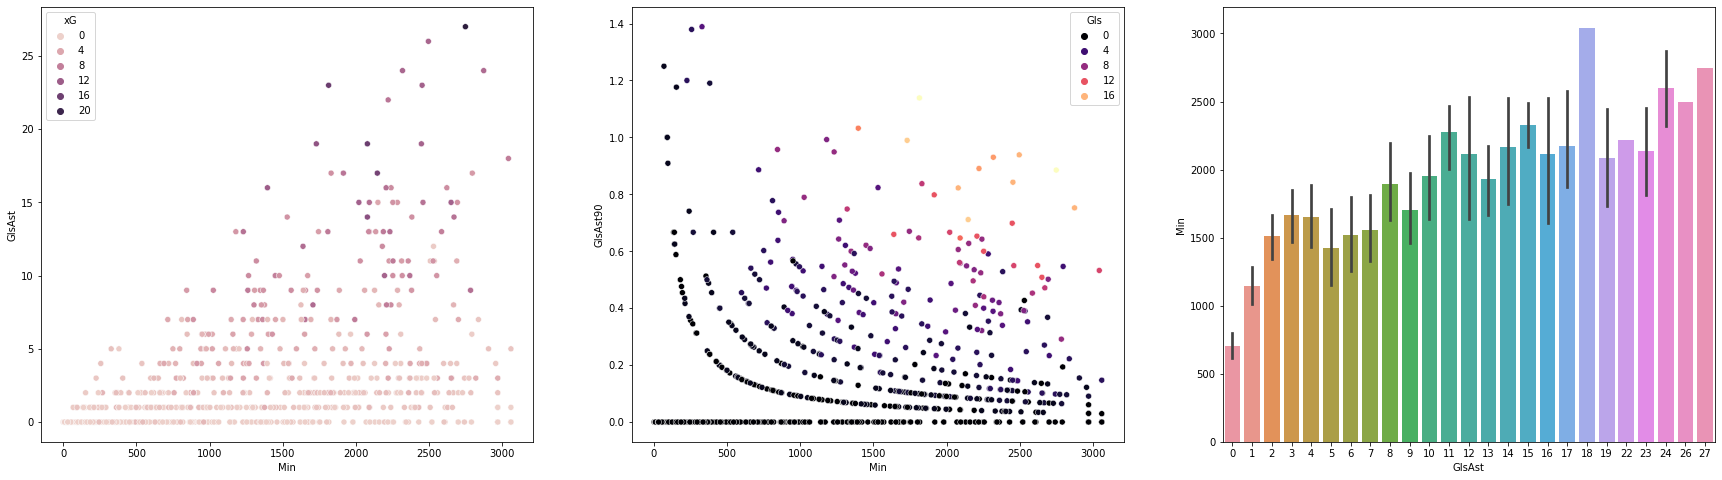

In [17]:
fig, axs = plt.subplots(ncols=3, figsize=(30,8))
sns.scatterplot(data = dataset, x = "Min", y = "GlsAst", hue = 'xG', ax=axs[0])
sns.scatterplot(data = dataset, x = 'Min', y = 'GlsAst90', hue = 'Gls', palette = 'magma', ax=axs[1])
sns.barplot(data = dataset, x = 'GlsAst', y = 'Min', ax=axs[2]);


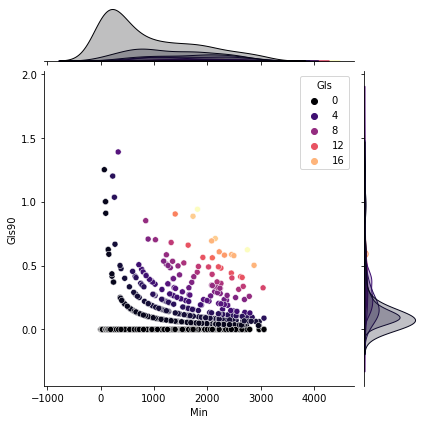

In [18]:
sns.jointplot(data = dataset, x = 'Min', y = 'Gls90', hue = 'Gls', palette = 'magma', ax=axs[1]);

In [19]:
model = BayesianRidge()
model.fit(x_train, y_train);

In [20]:
button = wid.Button(description="Calculate")
minutesText = wid.BoundedIntText(value=0,min=0,max=3060,step=1,description='Minutes:')
goalsText = wid.BoundedIntText(value=0,min=0,max=50,step=1,description='Goals:')
assistsText = wid.BoundedIntText(value=0,min=0,max=50,step=1,description='Assists:')
itemtext = [wid.HTML(value="Calculate expected goals + assists across an entire season of 3060 minutes, based on the amount of goals and assists achieved in the specified number of minutes.")]
items = [minutesText, goalsText, assistsText, button]
df = pd.DataFrame(np.array([[0, 0, 0]]), columns=['Min', 'Gls', 'Ast'])
answer = 0
answerText = wid.Text(value = str(answer), description='Goals + Assists')

In [21]:
def on_button_clicked(b):
    print("Button clicked.")
    df = pd.DataFrame(np.array([[minutesText.value, goalsText.value, assistsText.value]]), columns=['Min', 'Gls', 'Ast'])
    answer = int(np.ceil(max(0, (model.predict(df) * 34))))
    if answer < (int(goalsText.value) + int(assistsText.value)):
        answer = (int(goalsText.value) + int(assistsText.value))
    answerText.value = str(answer)

button.on_click(on_button_clicked)

topbox = HBox(children=itemtext)
bottombox = HBox(children=items)
box = VBox(children=[topbox, bottombox, answerText])
box

In [22]:
predicted = model.predict(x_test)
predicted[predicted < 0] = 0


Here the model is approximated over a scatterplot of data points.

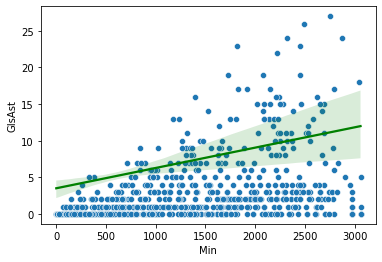

In [23]:
sns.scatterplot(x = dataset['Min'], y = dataset['GlsAst']);
sns.regplot(x = x_test['Min'], y = (predicted*34), color='g', scatter=False);


The following are the R2 score, followed by the Mean Squared Error

In [24]:
predict_test = model.predict(x_test)
print(metrics.r2_score((y_test), predicted))
print(metrics.mean_squared_error((y_test), predicted))
# print(model.score(x_test, y_test))


0.6613605550721013
0.01651472447840929
